In [33]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [34]:
path = 's3fd-20220422-171351'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [35]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [36]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-22 17:13:51.853612,1.0,5731463168
1,2022-04-22 17:14:05.067110,50.6,5330227200
2,2022-04-22 17:14:17.707610,53.4,5332434944
3,2022-04-22 17:14:31.123612,53.9,5323755520
4,2022-04-22 17:14:44.356610,53.9,5424148480
...,...,...,...
751,2022-04-22 19:51:52.936111,54.2,5288955904
752,2022-04-22 19:52:05.956612,59.5,5239504896
753,2022-04-22 19:52:17.904609,52.4,5155479552
754,2022-04-22 19:52:29.915111,56.3,5263818752


In [37]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

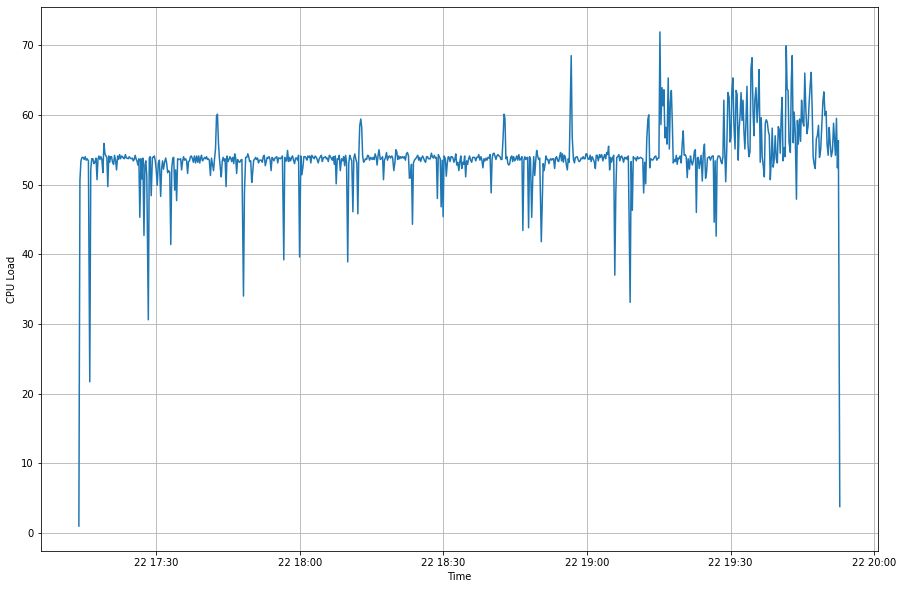

In [38]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

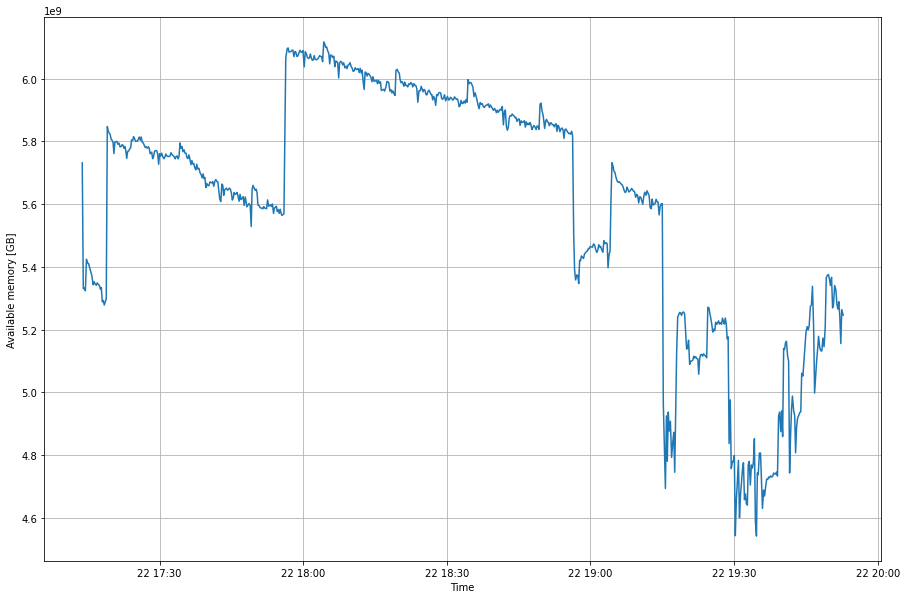

In [39]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

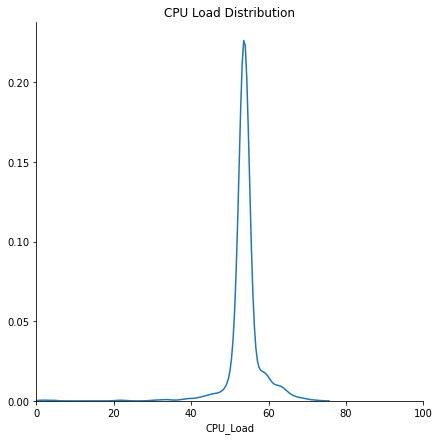

In [40]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

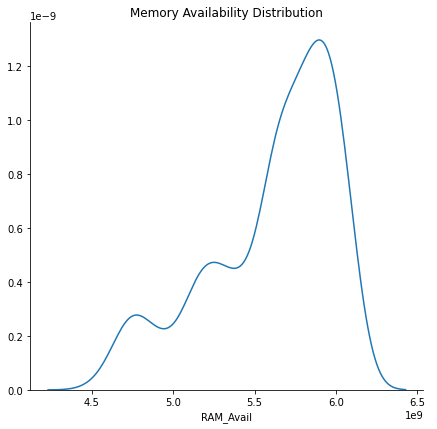

In [41]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [42]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-22 17:13:54.557110,2312576100,1.000000,1.000000,1.000000,"[0.9082491582491582, 0.9106326219512195, 0.923...",8,0,0,8,"[(909.0, 330.0, 975.0, 420.0), (717.0, 229.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-22 17:13:59.274610,4711850600,1.000000,1.000000,1.000000,[0.8413917758698599],1,0,0,1,"[(555.0, 1231.0, 695.0, 1329.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-22 17:14:01.612610,2330950400,1.000000,1.000000,1.000000,"[0.7413652434049497, 0.910828025477707]",2,0,0,2,"[(557.0, 115.0, 604.0, 174.0), (458.0, 46.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-22 17:14:05.066611,3328778600,1.000000,0.112903,0.202899,"[0.7245508982035929, 0.8570287539936102, 0.770...",7,0,55,62,"[(256.0, 496.0, 290.0, 540.0), (288.0, 431.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-22 17:14:07.109110,2022029100,1.000000,1.000000,1.000000,"[0.8683905827865689, 0.9119380987472365, 0.731...",8,0,0,8,"[(201.0, 76.0, 248.0, 129.0), (272.0, 70.0, 31...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-22 19:52:24.958111,4732761700,1.000000,1.000000,1.000000,[0.8202566140570001],1,0,0,1,"[(458.0, 159.0, 594.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-22 19:52:29.914610,4948513400,1.000000,1.000000,1.000000,"[0.8058540200074101, 0.7615869484612533]",2,0,0,2,"[(715.0, 420.0, 797.0, 536.0), (330.0, 416.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-22 19:52:32.663110,2644886700,0.931034,1.000000,0.964286,"[0.918918918918919, 0.9393939393939394, 0.7873...",27,2,0,27,"[(678.0, 490.0, 709.0, 526.0), (69.0, 307.0, 1...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-22 19:52:34.825634,2144715200,1.000000,0.857143,0.923077,"[0.9076054664289959, 0.7972865123703112, 0.831...",6,0,1,7,"[(854.0, 78.0, 901.0, 143.0), (753.0, 64.0, 78...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [43]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.902436e+09,0.889474,0.738624,0.769978,5.133292,0.260694,7.175449,12.308741
std,1.068273e+09,0.269349,0.345744,0.310751,11.315636,0.841143,31.969078,39.822258
min,8.219729e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.243933e+09,1.000000,0.500000,0.631749,1.000000,0.000000,0.000000,1.000000
50%,2.478080e+09,1.000000,1.000000,0.976177,2.000000,0.000000,0.000000,3.000000
75%,3.309450e+09,1.000000,1.000000,1.000000,5.000000,0.000000,3.000000,9.000000
max,1.657330e+10,1.000000,1.000000,1.000000,204.000000,16.000000,584.000000,709.000000


In [44]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,4445.960400,True,True,True
1,3493.232000,True,True,True
2,2566.523700,True,True,False
3,2562.509000,True,True,False
4,2475.888200,True,True,True
...,...,...,...,...
17396,11.771656,False,False,False
17397,11.155687,True,True,False
17398,10.661679,True,True,False
17399,9.116041,False,False,False


In [45]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [46]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,4445.960400,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,3493.232000,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,2566.523700,True,True,False,1.000000,0.000076,1.000000,0.000076,0.666667,0.000050
3,2562.509000,True,True,False,1.000000,0.000101,1.000000,0.000101,0.500000,0.000050
4,2475.888200,True,True,True,1.000000,0.000126,1.000000,0.000126,0.600000,0.000076
...,...,...,...,...,...,...,...,...,...,...
17396,11.771656,False,False,False,0.951773,0.416994,0.935391,0.409817,0.672645,0.294701
17397,11.155687,True,True,False,0.951776,0.417019,0.935395,0.409842,0.672606,0.294701
17398,10.661679,True,True,False,0.951779,0.417044,0.935399,0.409867,0.672567,0.294701
17399,9.116041,False,False,False,0.951724,0.417044,0.935345,0.409867,0.672529,0.294701


In [47]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

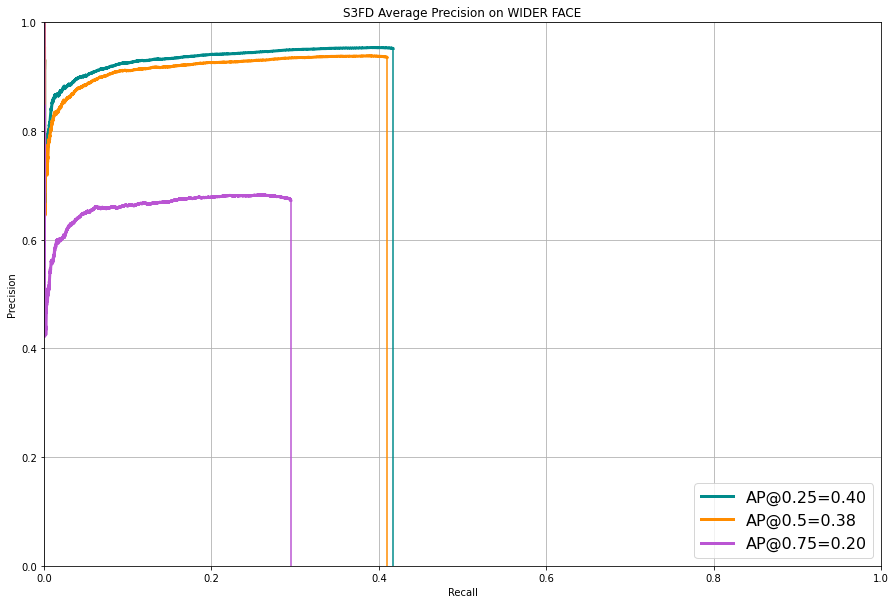

In [49]:
plot_pr(df_ap, 'S3FD Average Precision on WIDER FACE')